#### Imports

In [1]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import GroupShuffleSplit
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Load Data & Predprosessing

In [2]:
df = pd.read_csv("data/steam-200k.csv", header=None, index_col=None, names=['UserID', 'Game', 'Action', 'Hours', 'Other'])
df = df.drop(columns='Other')
df

,UserID,Game,Action,Hours
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0


Select all played games

In [3]:
df_played = df[df['Action'] == 'play'][['Game', 'Hours', 'UserID']]

#### Group by game and calculate quantiles

| Rating | Condition |
| --- | --- |
| 0 | Purchased Game, not played |
| 1 | Game time 0% quantile      |
| 2 | Game time 25% quantile     |
| 3 | Game time 50% quantile     |
| 4 | Game time 75% quantile     |
| 5 | Game time 100% quantile    |

In [4]:
df_grouped = df_played.groupby('Game').agg(
    Users=('UserID', len),
    Hours0=('Hours', lambda x: np.quantile(x, 0)),
    Hours25=('Hours', lambda x: np.quantile(x, 0.25)),
    Hours50=('Hours', lambda x: np.quantile(x, 0.5)), 
    Hours75=('Hours', lambda x: np.quantile(x, 0.75)),
    Hours100=('Hours', lambda x: np.quantile(x, 1))).reset_index()

In [5]:
df_filtered = df_grouped[df_grouped['Users'] >= 5]
df_agg = df.groupby(by=['UserID', 'Game']).agg({'Action': len, 'Hours': (lambda x: sum(x) - 1)}).reset_index()
df_merged = df_agg.merge(right=df_filtered, how='left', on=['Game'])

In [6]:
def rating(row):
    if row['Action'] == 1:
        return 0
    return np.interp(row['Hours'], [row['Hours0'], row['Hours25'], row['Hours50'], row['Hours75'], row['Hours100']], np.arange(1, 6))

In [7]:
df_merged['Rating'] = df_merged.apply(lambda row: rating(row), axis=1)
df_merged = df_merged[df_merged['Users'].notna()]
df_merged

,UserID,Game,Action,Hours,Users,Hours0,Hours25,Hours50,Hours75,Hours100,Rating
0,5250,Alien Swarm,2,4.9,289.0,0.1,0.600,2.20,6.000,83.0,3.710526
1,5250,Cities Skylines,2,144.0,115.0,0.2,6.500,15.30,40.000,285.0,4.424490
2,5250,Counter-Strike,1,0.0,568.0,0.1,1.300,8.80,101.000,4814.0,0.000000
3,5250,Counter-Strike Source,1,0.0,715.0,0.1,2.500,13.80,80.500,4676.0,0.000000
4,5250,Day of Defeat,1,0.0,94.0,0.1,0.300,1.15,4.375,257.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,2,6.7,200.0,0.1,3.225,9.00,25.000,682.0,2.601732
128800,309812026,Counter-Strike Nexon Zombies,1,0.0,184.0,0.1,0.300,0.80,6.025,269.0,0.000000
128801,309812026,Robocraft,1,0.0,407.0,0.1,0.700,3.60,15.350,700.0,0.000000
128802,309824202,Dota 2,2,0.7,4841.0,0.1,1.200,5.50,69.000,10442.0,1.545455


##### Pivot table
Rows are users

Columns are games

In [8]:
table = df_merged.pivot(index='UserID', columns='Game', values='Rating')
table = table.reset_index()
table = table.fillna(2.5)
table

Game,UserID,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),100% Orange Juice,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,140,3DMark,404Sight,60 Seconds!,7 Days to Die,...,Zeno Clash,Zombie Army Trilogy,Zombie Driver,Zombie Panic Source,Zombies Monsters Robots,ibb & obb,resident evil 4 / biohazard 4,sZone-Online,the static speaks my name,theHunter
0,5250,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
1,76767,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
2,86540,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
3,103360,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
4,144736,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12239,309554670,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12240,309626088,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12241,309812026,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12242,309824202,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


#### Train test split

In [9]:
splitter = GroupShuffleSplit(test_size=.02, n_splits=2, random_state = 42)
split = splitter.split(table, groups=table['UserID'])
train_inds, test_inds = next(split)

train = table.iloc[train_inds].drop('UserID', axis=1)
test = table.iloc[test_inds].drop('UserID', axis=1)
print(train.shape)
print(test.shape)

(11999, 1584)
(245, 1584)


### Models

#### BaseLine model (dummy model)
Unpersonalized recommendations - recommender most played games 

In [10]:
most_played_games = df[df['Action']=='play'].groupby('Game')['Game'].agg('count').sort_values(ascending=False)[:50].index.values

#### Nearest neighbour recommender

In [11]:
def get_games(result, query):
    best_games = {}
    games_played_by_query = query[query != 2.5].index.values

    for column in result:
        for _, row in result[[column]][result[column] != 2.5].iterrows():
            game = row.index[0]
            rated = row.iloc[0]
            if rated != 2.5 and rated > 0:
                if game in best_games:
                    best_games[game].append(rated)
                else:
                    best_games[game] = [rated]
    
    best_games_result = sorted([(key, len(value), np.mean(value)) for key, value in best_games.items() if len(value) >= 2 and np.mean(value) > 0], key=lambda x: x[2], reverse=True)

    return games_played_by_query, best_games_result[:50]


def recommend(table, query):
    distances = []

    for index, _ in enumerate(table.iterrows()):
        dst = np.linalg.norm(query[query != 2.5] - table.iloc[index][query != 2.5])
        distances.append((index, dst))
    distances.sort(key=lambda x: x[1])

    result = table.iloc[[x[0] for x in distances[:50]]]

    return get_games(result, query)

Example of Nearest neighbour recomemendation


In [12]:
played, recommended = recommend(train, train.iloc[8336]) # User index 847
print("Played:")
for p in played:
    print(p)
print()
print("Recommended:")
for r in recommended[:10]:
    print (r[0])

Played:
Clicker Heroes
Counter-Strike Global Offensive
Loadout
Sid Meier's Civilization V

Recommended:
Spintires
Time Clickers
Stronghold 2
Next Car Game Sneak Peek 2.0
Crusader Kings II
Crysis 2 Maximum Edition
Borderlands
AdVenture Capitalist
Far Cry 3
Fallout 3


#### Clustering recommender 
(clusters are groups of users)

In [13]:
train

Game,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),100% Orange Juice,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,140,3DMark,404Sight,60 Seconds!,7 Days to Die,8BitBoy,...,Zeno Clash,Zombie Army Trilogy,Zombie Driver,Zombie Panic Source,Zombies Monsters Robots,ibb & obb,resident evil 4 / biohazard 4,sZone-Online,the static speaks my name,theHunter
0,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
1,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
2,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
3,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
4,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12239,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12240,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12241,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5
12242,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


In [14]:
kmeans_users = KMeans(n_clusters=10, random_state=42).fit(train.values)

In [15]:
def recommend_clustering_users(table, query):
    
    cluster_number = kmeans_users.predict(query.to_numpy().reshape(1,-1))[0]
    cluster_table = table.iloc[kmeans_users.labels_ == cluster_number]

    return get_games(cluster_table, query)

Example of recommendation

In [16]:
recommend_clustering_users(train, test.iloc[[3]])

(array([200]),
 [('Revenge of the Titans', 2, 4.786096256684492),
  ('The Chronicles of Riddick Assault on Dark Athena', 2, 4.612456747404844),
  ('Pinball FX2', 3, 4.606885322167947),
  ('Commandos Behind Enemy Lines', 2, 4.5850622406639),
  ('Plain Sight', 2, 4.552631578947368),
  ('Before the Echo', 2, 4.540481400437637),
  ('Strike Suit Infinity', 2, 4.539823008849558),
  ('Galaxy on Fire 2 Full HD', 4, 4.530758140093717),
  ('Back to the Future Ep 2 - Get Tannen!', 2, 4.523809523809523),
  ('Alien Breed Impact', 2, 4.5),
  ('Bleed', 2, 4.5),
  ('DuckTales Remastered', 2, 4.5),
  ('Invisible, Inc.', 2, 4.5),
  ('Majesty 2 Collection', 2, 4.5),
  ('Men of War Vietnam', 2, 4.5),
  ('One Way Heroics', 2, 4.5),
  ('Warlock 2 the Exiled', 2, 4.5),
  ('Zombie Army Trilogy', 2, 4.5),
  ('Steel Storm Burning Retribution', 3, 4.384615384615384),
  ('Indiana Jones and the Fate of Atlantis', 3, 4.333333333333333),
  ('Binary Domain', 2, 4.262820512820513),
  ('Blur', 3, 4.25748502994012),
  (

/home/betty/miniconda3/envs/doodle/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Text(0, 0.5, 'PCA 2')

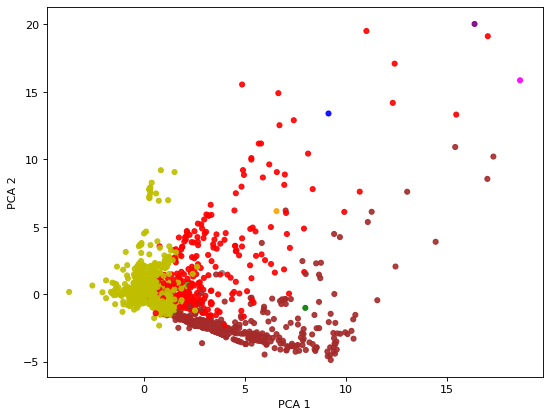

In [17]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train)
colors = np.array(['limegreen', 'y', 'orange', 'green', 'brown', 'magenta', 'purple', 'red', 'gray', 'blue'])
predicted_clusters = kmeans_users.predict(train)
figure(figsize=(8, 6), dpi=80)
plt.scatter(principalComponents[:,0], principalComponents[:,1], alpha=.9, color=colors[predicted_clusters], s=20)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

#### Clustering recommender 
(clusters are groups of games)

In [18]:
table_games = train.transpose()
kmeans_games = KMeans(n_clusters=10, random_state=42).fit(table_games.reset_index().drop("Game", axis=1))

Text(0, 0.5, 'PCA 2')

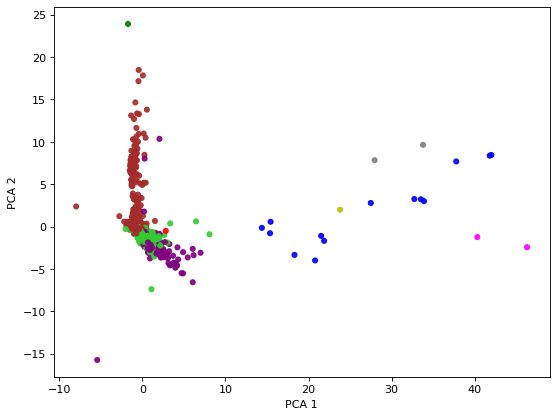

In [19]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(table_games)
colors = np.array(['blue', 'y', 'purple', 'green', 'brown', 'magenta', 'purple', 'red', 'gray', 'limegreen'])
predicted_clusters = kmeans_games.predict(table_games)
figure(figsize=(8, 6), dpi=80)
plt.scatter(principalComponents[:,0], principalComponents[:,1], alpha=.9, color=colors[predicted_clusters], s=20)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Example of the cluster for the game "Dungeonland"

In [20]:
query_cluster = kmeans_games.predict([table_games.loc['Portal 2']])[0]
cluster = table_games[kmeans_games.labels_ == 3].reset_index()
cluster

,Game,0,1,2,3,4,5,6,7,8,...,12234,12235,12236,12237,12238,12239,12240,12241,12242,12243
0,Warframe,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,...,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5


### Evaluation

In [21]:
def evaluate(recommender):
    test_copy = test.copy()
    list_recall_model = []
    list_recall_dummy = []
    for _, row in test_copy.iterrows():
        total_played_games = len(row[row != 2.5])
        if total_played_games >= 20:
            games = list(row[row != 2.5].index.values) # played games 
            sample = random.sample(games, total_played_games // 2) # deleted games
            row_new = row[:]
            row_new[sample] = 2.5
            _, recommended = recommender(train, row_new) 
            recommended_games = [game[0] for game in recommended] # recommended games

            # number of games of intersection between deleted and recommender games => good recommendation
            intersection = len(list(set(sample) & set(recommended_games)))
            intersection_dummy = len(list(set(sample) & set(most_played_games)))
            list_recall_model.append(intersection / len(sample))
            list_recall_dummy.append(intersection_dummy / len(sample))

    print(f"Evaluated system: Average recall: {np.mean(list_recall_model):.4f} Median recall: {np.median(list_recall_model):.4f}")
    print(f"BaseLine system:  Average recall: {np.mean(list_recall_dummy):.4f} Median recall: {np.median(list_recall_dummy):.4f}")

#### Evaluation of Nearest neighbour recommender

In [22]:
evaluate(recommend)

Evaluated system: Average recall: 0.0647 Median recall: 0.0526
BaseLine system:  Average recall: 0.2421 Median recall: 0.2632


#### Evaluation of Clustering recommender (clusters are groups of games)

In [23]:
evaluate(recommend_clustering_users)

Evaluated system: Average recall: 0.0040 Median recall: 0.0000
BaseLine system:  Average recall: 0.2619 Median recall: 0.2632
